In [11]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp

from torch import nn
import scanpy as sc    
import muon as mu

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"
sc.settings.figdir = 'figures'  # Directory to save figures
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(6, 6)) 

## Step 1: Initialize data

In [12]:
dataset_config = {"dataset_path": DATA_DIR / "processed" / "atac" / "pbmc" / "pbmc10k_multiome_test.h5mu",
                    "layer_key": "X_counts",
                    "covariate_keys": ["cell_type"],
                    "conditioning_covariate": "cell_type",
                    "subsample_frac": 1,
                    "encoder_type": "learnt_autoencoder",
                    "target_max": 1,
                    "target_min": -1,
                    "one_hot_encode_features": False,
                    "split_rates": [0.80, 0.10, 0.10],
                    "cov_embedding_dimensions": 100,
                    "multimodal": True,
                    "is_binarized": True
                }

data_path = dataset_config["dataset_path"]
dataset = RNAseqLoader(data_path = data_path,
                        layer_key=dataset_config["layer_key"],
                        covariate_keys=dataset_config["covariate_keys"],
                        subsample_frac=dataset_config["subsample_frac"], 
                        encoder_type=dataset_config["encoder_type"], 
                        multimodal=dataset_config["multimodal"],
                        is_binarized=dataset_config["is_binarized"])

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


## Step 2: Initialize encoder

In [66]:
encoder_config = {"x0_from_x_kwargs": 
                      {"rna": {"dims": [512, 300, 100],
                               "batch_norm": True,
                               "dropout": False,
                               "dropout_p": 0.0},
                       "atac": {"dims": [1024, 512, 100],
                               "batch_norm": True,
                               "dropout": False,
                               "dropout_p": 0.0}},
                    "learning_rate": 0.001,
                    "weight_decay": 0.00001,
                    "covariate_specific_theta": False,
                    "multimodal": True, 
                    "is_binarized": True,
                    "encoder_multimodal_joint_layers":
                        {"dims": [100],
                        "batch_norm": False,
                        "dropout": False, 
                        "dropout_p": 0.0}
                 }

state_dict_path = "/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/train_autoencoder_pbmc10k_multimodal_joint/64584c28-b271-40b4-8279-562f583f649b/checkpoints/last.ckpt"

In [67]:
gene_dim = {mod: dataset.X[mod].shape[1] for mod in dataset.X}
modality_list = list(gene_dim.keys())
in_dim = {}

for mod in dataset.X:
    if dataset_config["encoder_type"]!="learnt_autoencoder":
        in_dim[mod] = gene_dim[mod]
    else:
        in_dim[mod] = encoder_config["x0_from_x_kwargs"][mod]["dims"][-1]
                    
size_factor_statistics = {"mean": {mod: dataset.log_size_factor_mu[mod] for mod in dataset.log_size_factor_mu}, 
                            "sd": {mod: dataset.log_size_factor_sd[mod] for mod in dataset.log_size_factor_sd}}


n_cat = len(dataset.id2cov["cell_type"])

In [68]:
encoder_model = EncoderModel(in_dim=gene_dim,
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

encoder_model.eval()

EncoderModel(
  (x0_from_x): ModuleDict(
    (rna): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=25604, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=300, bias=True)
          (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=300, out_features=100, bias=True)
      )
    )
    (atac): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=40086, out_features=1024, bias=True)
          (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=1024, out_features=512, bias=True)
         

## Initialize FM model

In [69]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.0001
                        }

In [70]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/fm_resnet_autoencoder_pbmc10k_multimodal_joint/bfde6062-7515-4517-8a75-7bfcdfffa3aa/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model

MLPTimeStep(
  (time_embedder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): SiLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (net_in): Linear(in_features=100, out_features=64, bias=True)
  (blocks): ModuleList(
    (0-2): 3 x ResnetBlock(
      (net1): Sequential(
        (0): SiLU()
        (1): Linear(in_features=64, out_features=64, bias=True)
      )
      (cond_proj): Sequential(
        (0): SiLU()
        (1): Linear(in_features=100, out_features=64, bias=True)
      )
      (net2): Sequential(
        (0): SiLU()
        (1): Linear(in_features=64, out_features=64, bias=True)
      )
    )
  )
  (net_out): Sequential(
    (0): SiLU()
    (1): Linear(in_features=64, out_features=100, bias=True)
  )
)

In [71]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[ 0.9949, -0.9152, -0.3694,  ..., -1.0313,  0.1756, -0.8770],
        [-1.4792,  0.2020, -1.2970,  ...,  0.6936, -0.2902, -1.4690],
        [-0.8759,  1.2364, -1.3428,  ...,  1.2052,  0.7412, -0.8084],
        ...,
        [-1.7338,  0.8173, -0.7834,  ..., -0.6681, -1.4251, -0.7958],
        [-1.7817,  1.3232, -0.2366,  ..., -1.6813,  1.4831,  1.3167],
        [ 0.3691,  0.8387,  2.0551,  ...,  1.1550, -1.0155,  0.6429]],
       device='cuda:0', requires_grad=True)


Initializations

In [72]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=in_dim,
            size_factor_statistics=size_factor_statistics,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            multimodal=dataset_config["multimodal"],
            is_binarized=dataset_config["is_binarized"], 
            modality_list=modality_list,
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): ModuleDict(
      (rna): MLP(
        (net): Sequential(
          (0): Sequential(
            (0): Linear(in_features=25604, out_features=512, bias=True)
            (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          (1): Sequential(
            (0): Linear(in_features=512, out_features=300, bias=True)
            (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          (2): Linear(in_features=300, out_features=100, bias=True)
        )
      )
      (atac): MLP(
        (net): Sequential(
          (0): Sequential(
            (0): Linear(in_features=40086, out_features=1024, bias=True)
            (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          (1): Sequential(
       

**Check the data**

In [20]:
adata_original = mu.read(data_path)
adata_rna = adata_original.mod["rna"]
adata_atac = adata_original.mod["atac"]
adata_rna.obs["size_factor"]=adata_rna.X.A.sum(1)
adata_atac.obs["size_factor"]=adata_atac.X.A.sum(1)
X_rna = torch.tensor(adata_rna.layers["X_counts"].todense())
X_atac = torch.tensor(adata_atac.layers["X_counts"].todense())

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [21]:
adata_rna

AnnData object with n_obs × n_vars = 2000 × 25604
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'size_factor'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts', 'count'
    obsp: 'connectivities', 'distances'

In [22]:
adata_atac.obs.cell_type = adata_rna.obs.cell_type

**Collect checkpoints and run**

General conditional

In [23]:
X_generated_list_rna = []
X_generated_list_atac = []

classes_str = []

for _ in tqdm(range(2)):
    num_indices =1000
    index_range = len(X_rna)
    
    # Generate random dummy indices without replacement
    indices = random.sample(range(index_range), num_indices)
    adata_rna_indices = adata_rna[indices]
    adata_atac_indices = adata_atac[indices]
    
    classes =  list(adata_rna_indices.obs.cell_type)
    classes_str += classes
    classes = torch.tensor([dataset.id2cov["cell_type"][c] for  c in classes]).cuda()

    # log_size_factors = {"rna": torch.log(torch.tensor(adata_rna_indices.layers["X_counts"].sum(1))).cuda(),
    #                     "atac": torch.log(torch.tensor(adata_atac_indices.layers["X_counts"].sum(1))).cuda()}
    log_size_factors = torch.log(torch.tensor(adata_rna_indices.layers["X_counts"].sum(1))).cuda()
    
    X_generated = generative_model.batched_sample(batch_size=100,
                                                repetitions=10,
                                                n_sample_steps=2, 
                                                covariate="cell_type", 
                                                covariate_indices=classes, 
                                                log_size_factor=log_size_factors)

    X_generated_list_rna.append(X_generated["rna"].to("cpu"))
    X_generated_list_atac.append(X_generated["atac"].to("cpu"))

100%|██████████| 2/2 [00:08<00:00,  4.31s/it]


In [24]:
X_generated_rna_list = torch.cat(X_generated_list_rna, dim=0)
X_generated_atac_list = torch.cat(X_generated_list_atac, dim=0)

In [25]:
# X_generated_list.shape

Single condition

In [26]:
# dataset.id2cov["cell_type"]

In [27]:
# # Pick condition 
# condition_name = "Normoblast"
# condition_val = dataset.id2cov["cell_type"][condition_name]
# adata_cond = adata_original[adata_original.obs.cell_type==condition_name]
# n_to_generate = adata_cond.shape[0]

# classes = condition_val*torch.ones(n_to_generate).long()
# classes_str = [condition_name for _ in range(n_to_generate)]


# log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [28]:
# X_generated = generative_model.sample(batch_size=n_to_generate,
#                                         n_sample_steps=100, 
#                                         covariate="cell_type", 
#                                         covariate_indices=classes, 
#                                         log_size_factor=log_size_factors)

# X_generated_list= X_generated.to("cpu")

**Create adata and check plots**

In [29]:
adata_generated_rna = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated_rna_list).cpu().numpy()))
adata_generated_rna.obs["size_factor"] = adata_generated_rna.X.sum(1)
adata_generated_atac = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated_atac_list).cpu().numpy()))
adata_generated_atac.obs["size_factor"] = adata_generated_atac.X.sum(1)

In [30]:
sc.pp.log1p(adata_generated_rna)
sc.tl.pca(adata_generated_rna)
sc.pp.neighbors(adata_generated_rna)
sc.tl.umap(adata_generated_rna)

In [31]:
sc.pp.log1p(adata_generated_atac)
sc.tl.pca(adata_generated_atac)
sc.pp.neighbors(adata_generated_atac)
sc.tl.umap(adata_generated_atac)

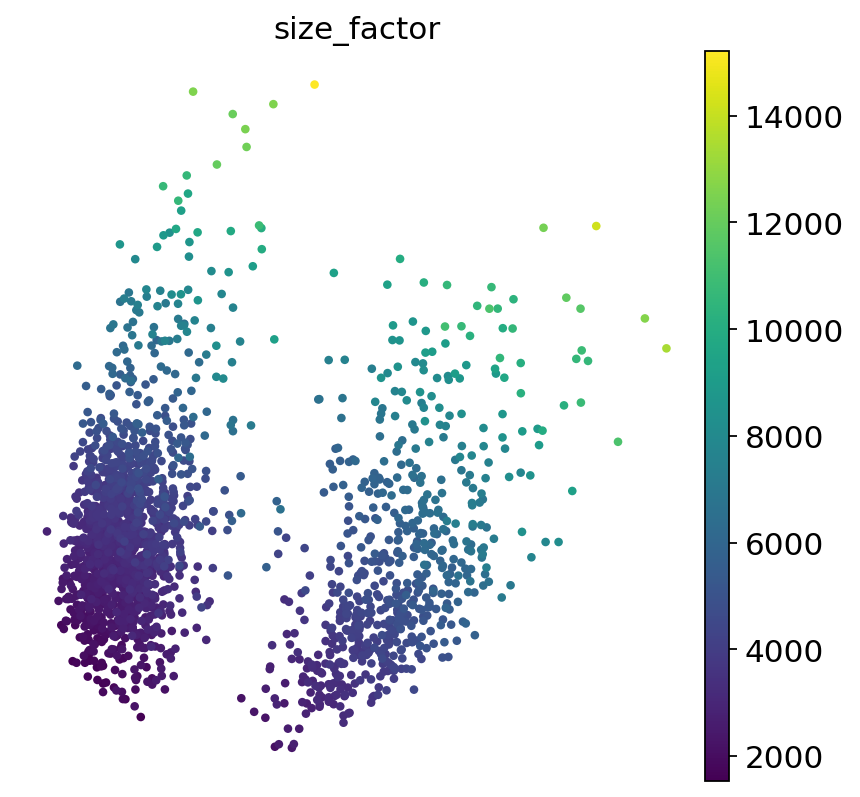

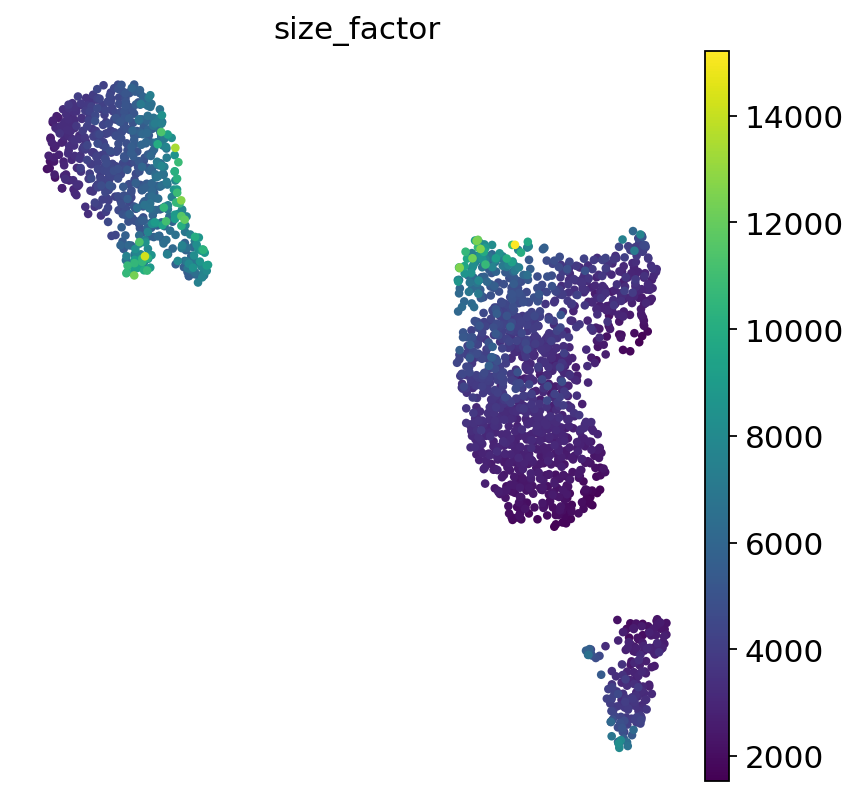

In [32]:
sc.pl.pca(adata_generated_rna, color="size_factor", annotate_var_explained=True)
sc.pl.umap(adata_generated_rna, color="size_factor")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


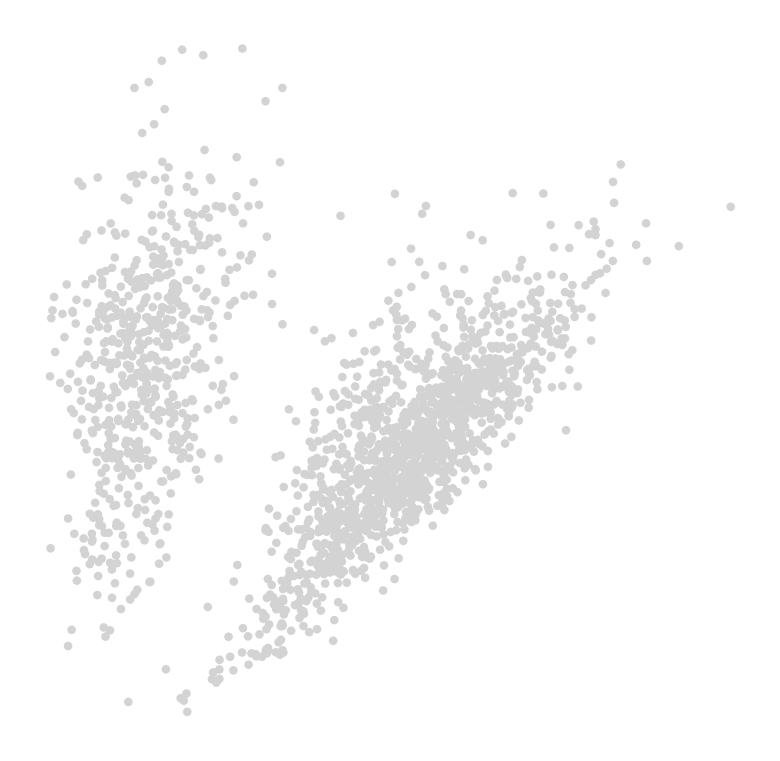

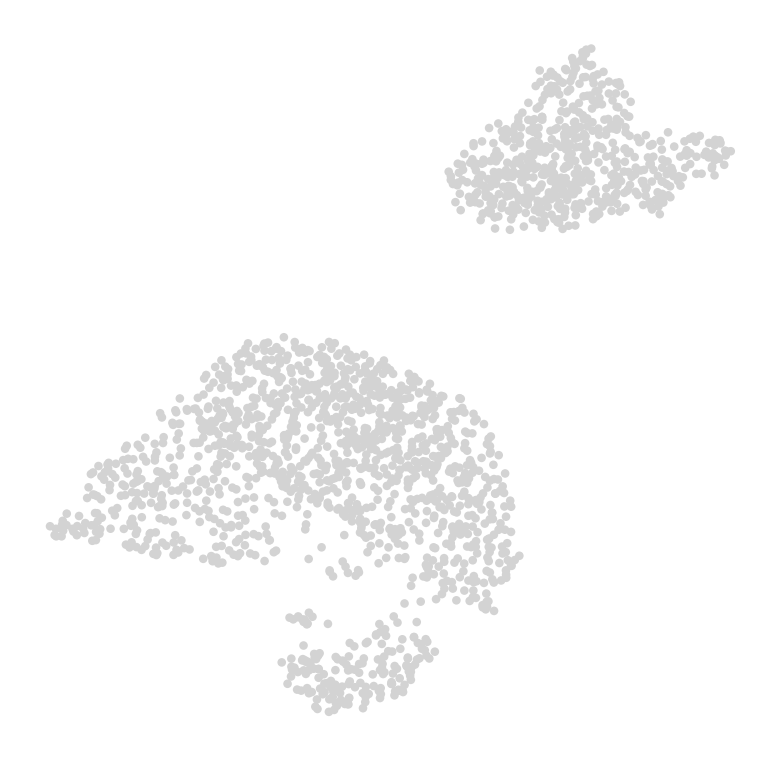

In [33]:
sc.pl.pca(adata_generated_atac, annotate_var_explained=True)
sc.pl.umap(adata_generated_atac)

Merge and plot the generated and real data

In [34]:
dataset_type_rna = ["Real" for _ in range(X_rna.shape[0])] + ["Generated" for _ in range(X_generated_rna_list.shape[0])]
dataset_type_rna = pd.DataFrame(dataset_type_rna)
dataset_type_rna.columns = ["dataset_type"]
dataset_type_rna["classes"] = list(adata_rna.obs.cell_type)+list(classes_str)

In [35]:
dataset_type_atac= ["Real" for _ in range(X_atac.shape[0])] + ["Generated" for _ in range(X_generated_atac_list.shape[0])]
dataset_type_atac = pd.DataFrame(dataset_type_atac)
dataset_type_atac.columns = ["dataset_type"]
dataset_type_atac["classes"] = list(adata_atac.obs.cell_type)+list(classes_str)

In [36]:
adata_merged_rna = sc.AnnData(X=torch.cat([X_rna, X_generated_rna_list], dim=0).numpy(), 
                             obs=dataset_type_rna)

adata_merged_atac = sc.AnnData(X=torch.cat([X_atac, X_generated_atac_list], dim=0).numpy(), 
                             obs=dataset_type_atac)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [37]:
sc.pp.log1p(adata_merged_rna) 
sc.tl.pca(adata_merged_rna)
sc.pp.neighbors(adata_merged_rna)
sc.tl.umap(adata_merged_rna)

## 

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


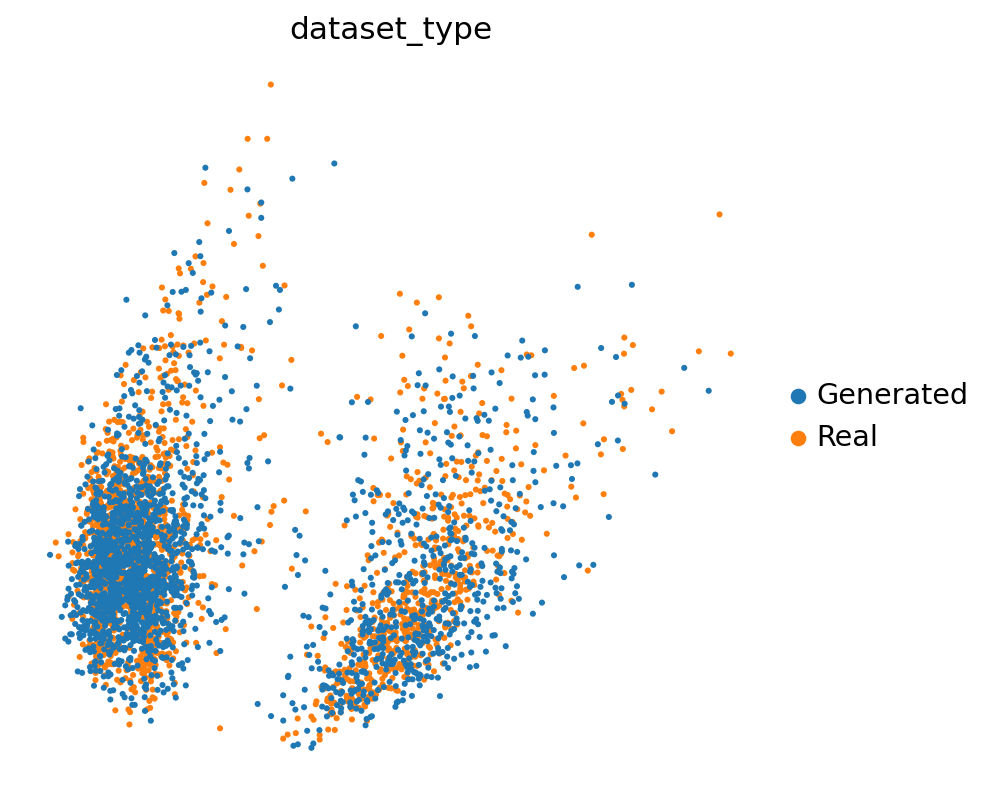

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

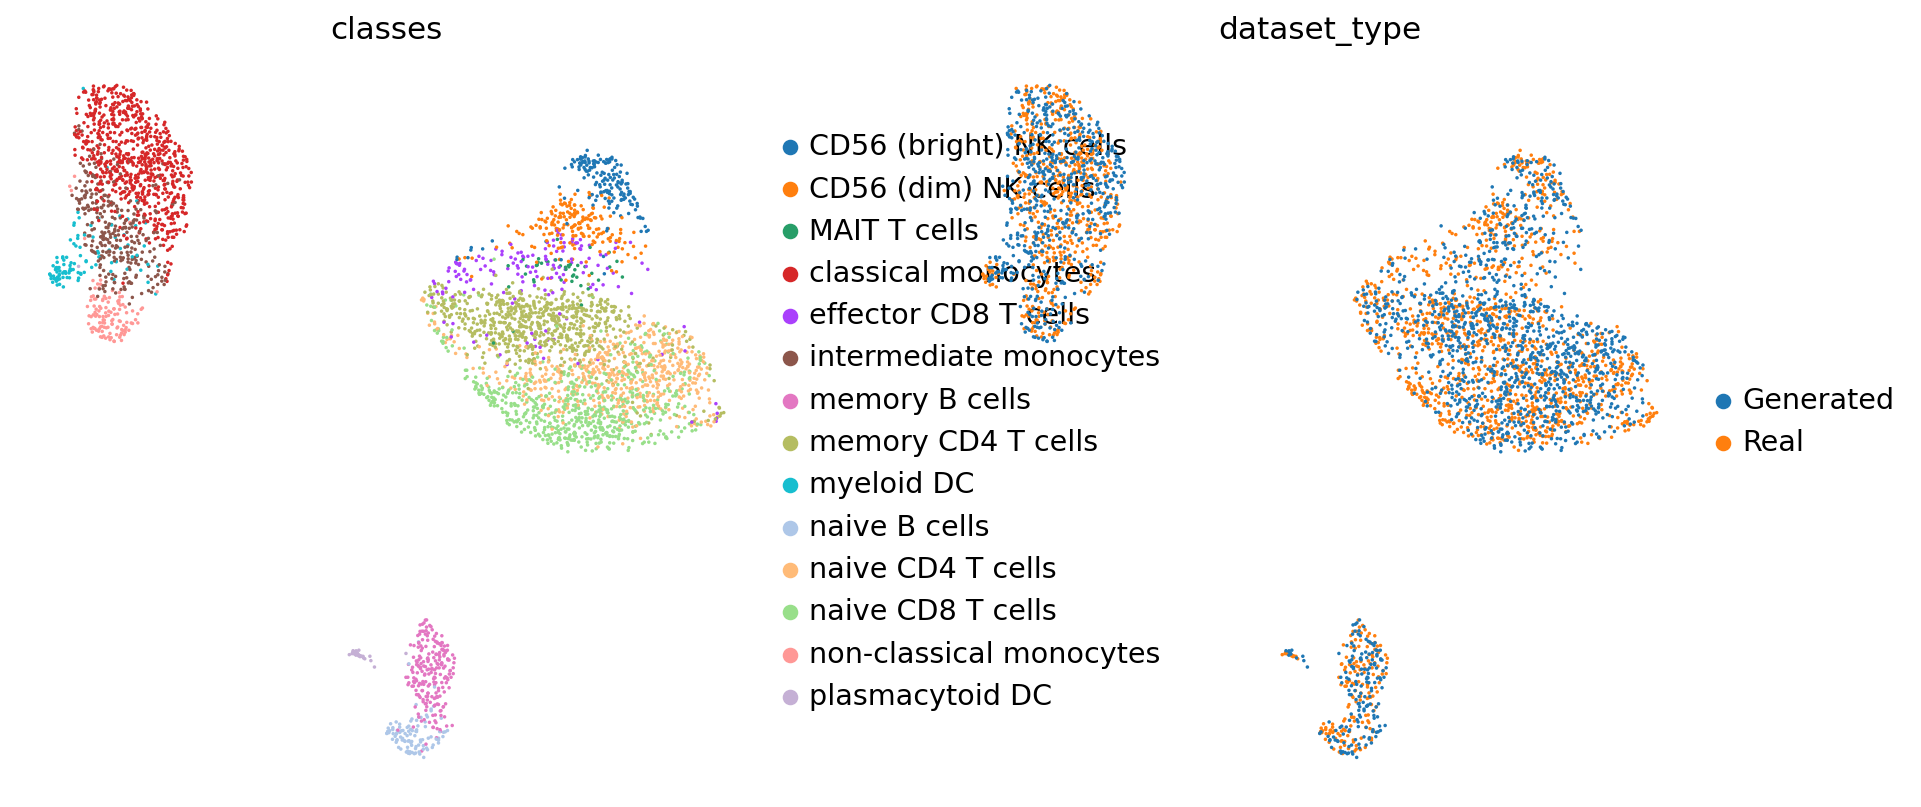

In [38]:
sc.pl.pca(adata_merged_rna, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged_rna, color=["classes","dataset_type"], s=10)

In [39]:
sc.pp.log1p(adata_merged_atac) 
sc.tl.pca(adata_merged_atac)
sc.pp.neighbors(adata_merged_atac)
sc.tl.umap(adata_merged_atac)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


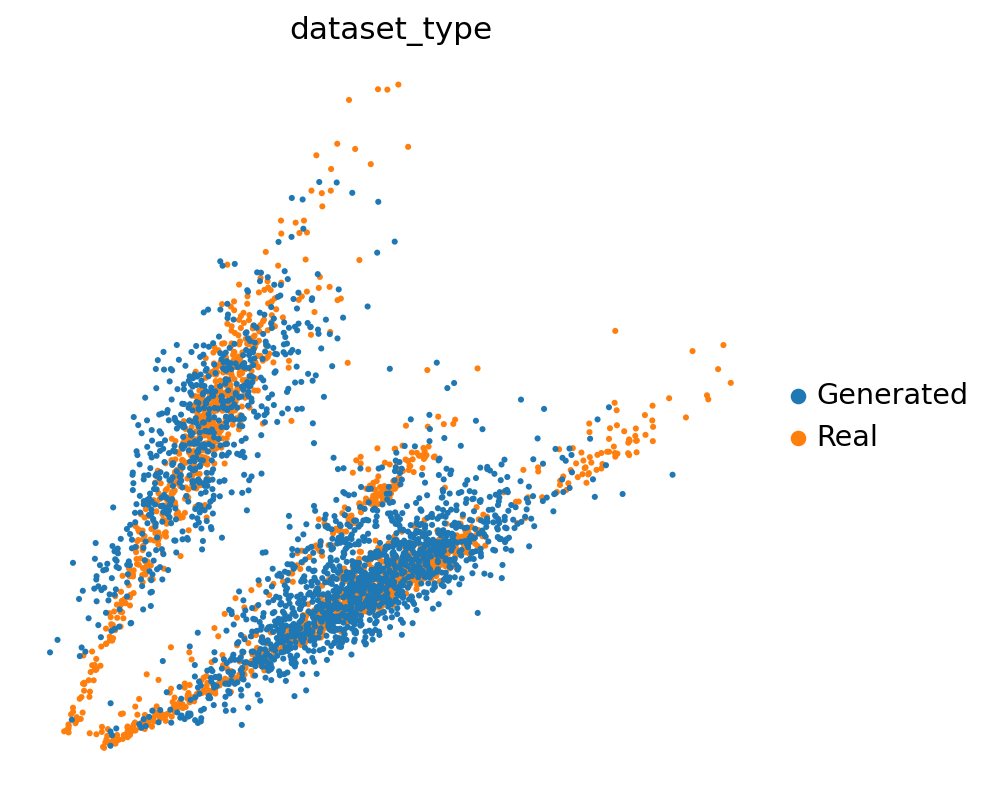

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

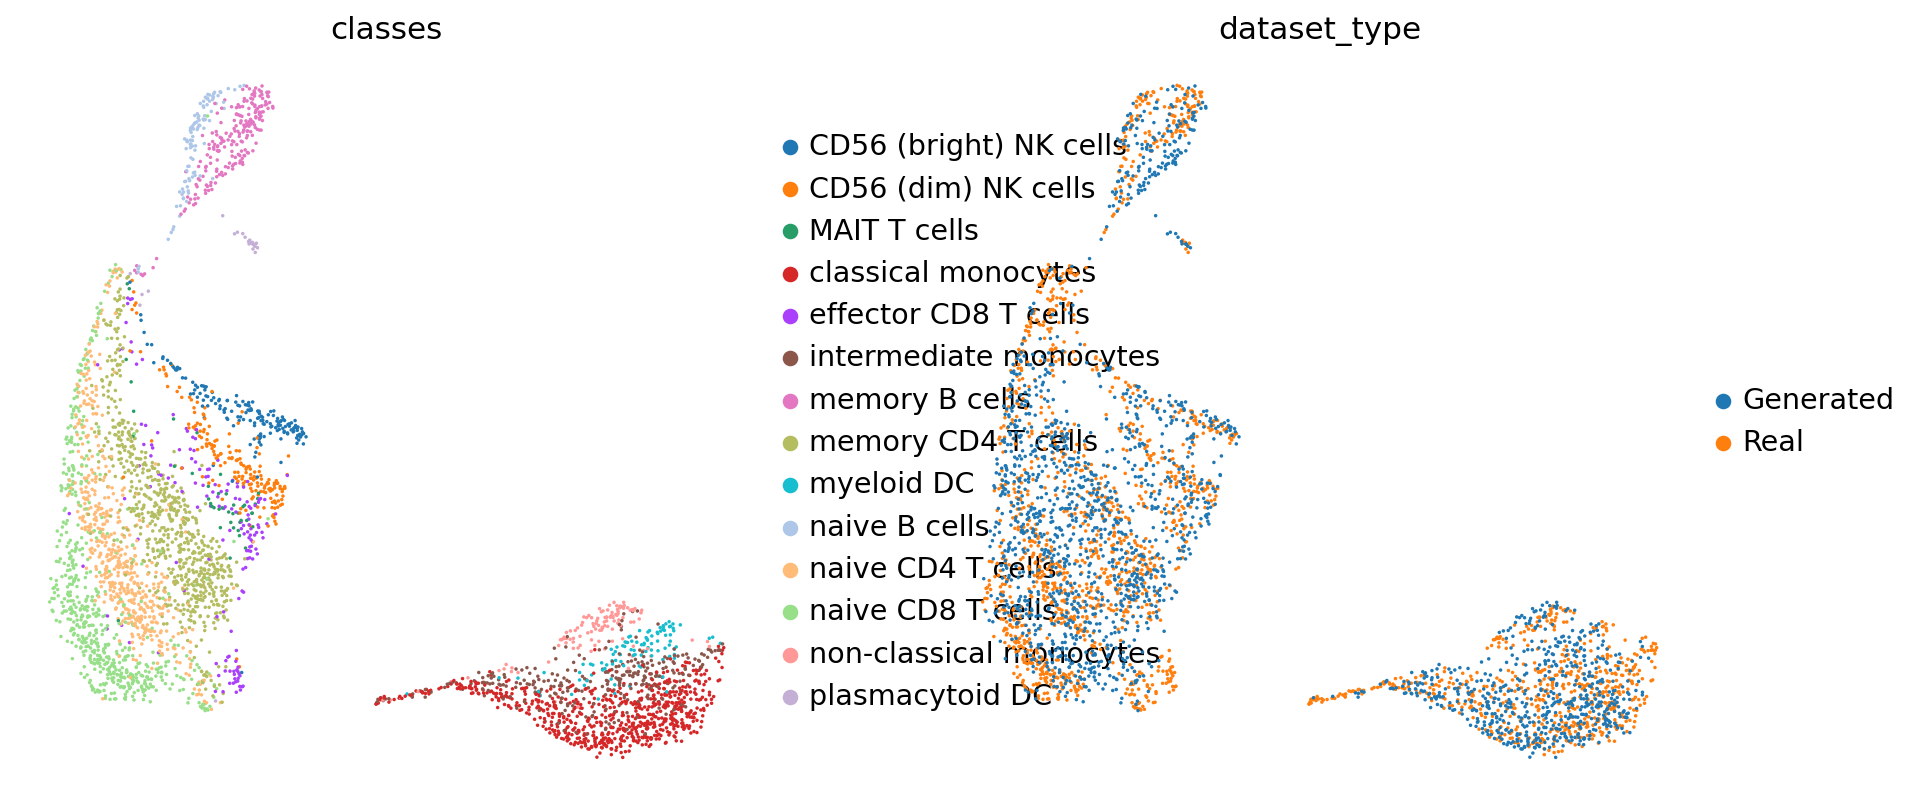

In [40]:
sc.pl.pca(adata_merged_atac, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged_atac, color=["classes","dataset_type"], s=10)

## Markers

In [41]:
adata_generated_atac.obs["cell_type"] = classes_str

In [42]:
adata_generated_atac.var = adata_atac.var.copy()

In [43]:
marker_peaks = [
    'chr14:99255246-99275454', 'chr10:33135632-33141841',                              # T/NK
    'chr1:1210271-1220028',                                                            # memory T/NK
    'chr2:86783559-86792275',                                                          # CD8+ T/NK
    'chr12:10552886-10555668',                                                         # naïve CD8+ T
    'chr11:114072228-114076352',                                                       # MAIT/NK
    # 'chr5:150385442-150415310',                                                        # B and mono (CD74)
    'chr22:41931503-41942227', 'chr22:41917087-41929835', 'chr6:167111604-167115345',  # B
    'chr9:107480158-107492721', 'chr5:1476663-1483241',                                # mono
    'chr10:75399596-75404660', 'chr1:220876295-220883526',                             # mDC
    'chr17:81425658-81431769'                              # pDC
]

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via '

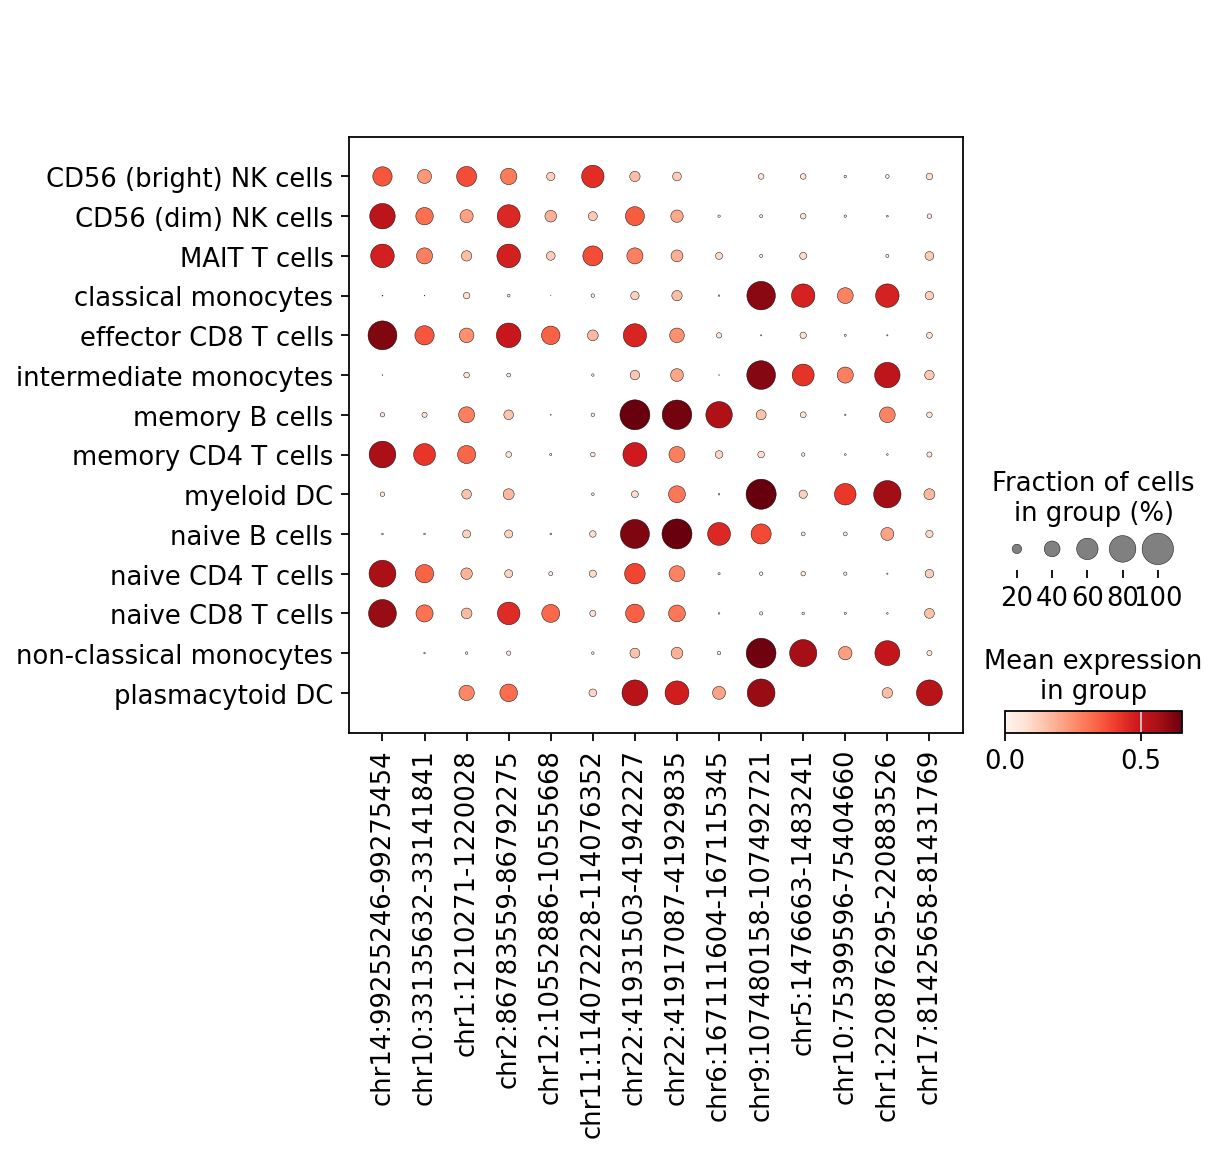

In [44]:
sc.pl.dotplot(adata_generated_atac, marker_peaks, 'cell_type')

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via '

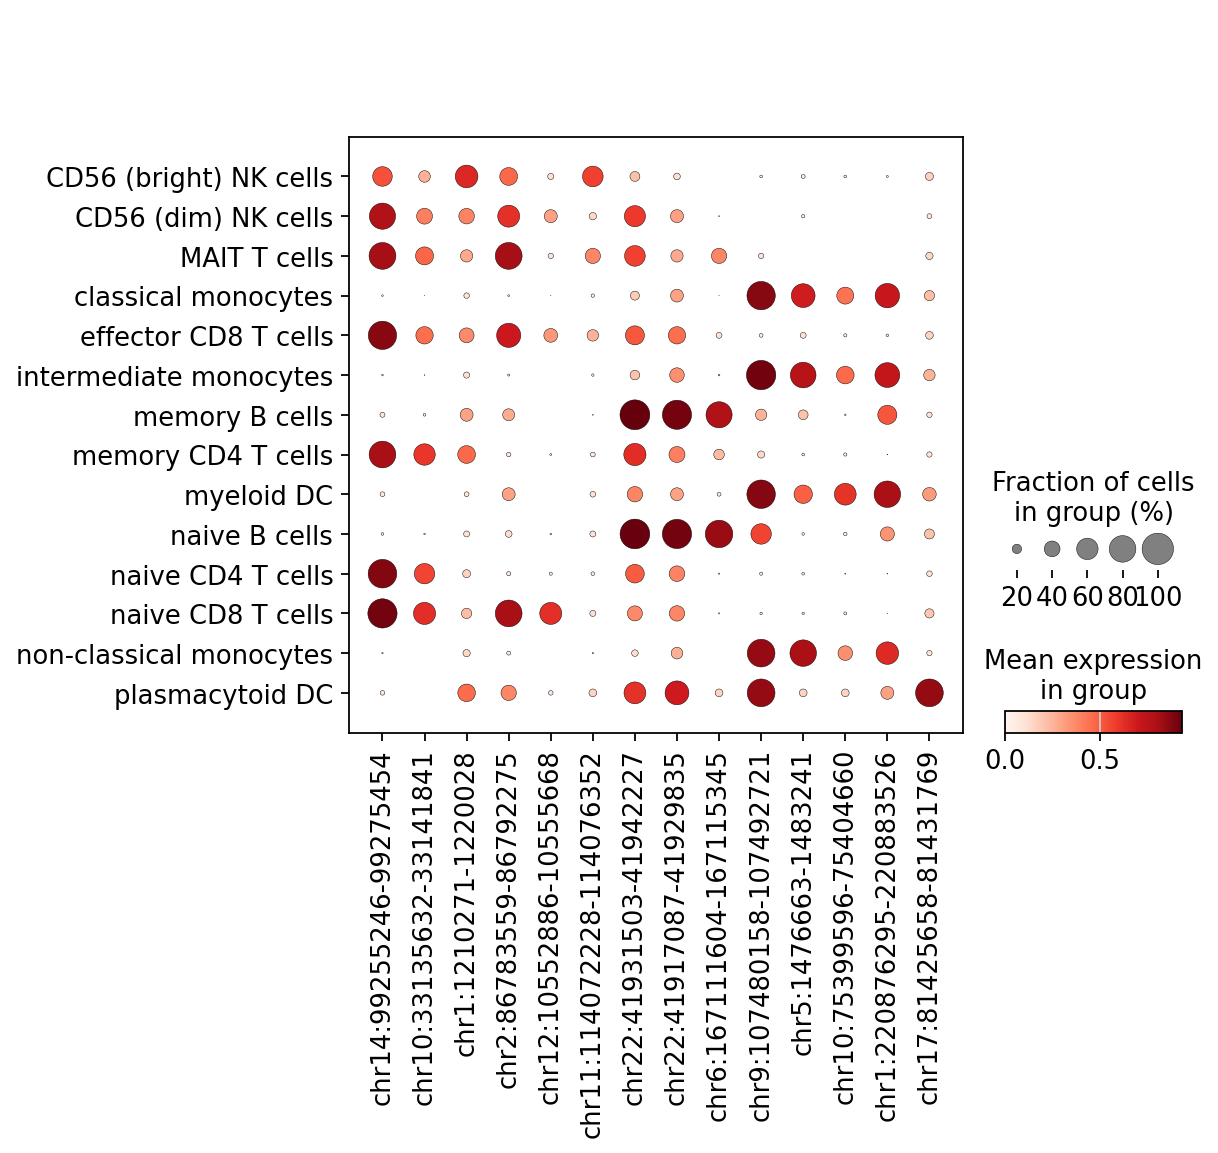

In [45]:
sc.pl.dotplot(adata_atac, marker_peaks, 'cell_type')

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcore.py:1498:

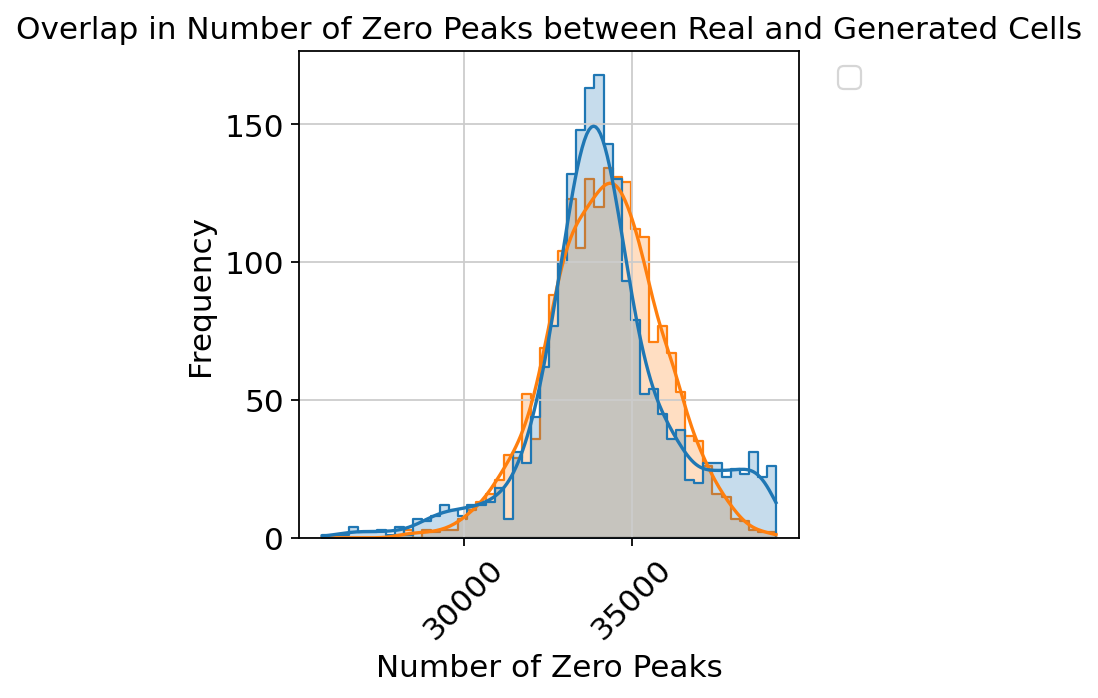

In [46]:
# Separate the number of zero genes for real and generated cells
import seaborn as sns

real_cells_zeros = list((adata_atac.X.A==0).sum(1))
generated_cells_zeros = list((adata_generated_atac.X.A==0).sum(1))

# Create a DataFrame for plotting with Seaborn
df = pd.DataFrame({
    'Number of zeros per cell': real_cells_zeros+generated_cells_zeros,
    'Dataset type': ["Real" for _ in range(len(real_cells_zeros))] + ["Generated" for _ in range(len(generated_cells_zeros))]
})

# Plot histogram using Seaborn
plt.figure(figsize=(4, 4))
sns.histplot(data=df, x='Number of zeros per cell', hue='Dataset type', element='step', bins=50, kde=True)
plt.xlabel('Number of Zero Peaks')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Overlap in Number of Zero Peaks between Real and Generated Cells')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [47]:
adata_generated_atac

AnnData object with n_obs × n_vars = 2000 × 40086
    obs: 'size_factor', 'cell_type'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [48]:
adata_atac

AnnData object with n_obs × n_vars = 2000 × 40086
    obs: 'cell_type', 'size_factor'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts', 'cpm_norm', 'tf-idf'
    obsp: 'connectivities', 'distances'

# Plot like paper

In [50]:
import numpy as np
import scanpy as sc
import pandas as pd
import scipy as sp
import muon as mu
from muon import atac as ac
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
import seaborn as sns
# sc.set_figure_params(dpi=800)
matplotlib.rcdefaults()

from pathlib import Path
matplotlib_rc = { 
    # 'text': {'usetex': True}, 
    'font': {'family': 'serif'} } # Apply changes for k, v in matplotlib_rc.items(): rc(k, **v)
for k, v in matplotlib_rc.items():
          rc(k, **v)

from matplotlib import rcParams

FIGSIZE = (5, 5)
rcParams["figure.figsize"] = FIGSIZE

In [57]:
palette = sns.color_palette("colorblind", as_cmap=False)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


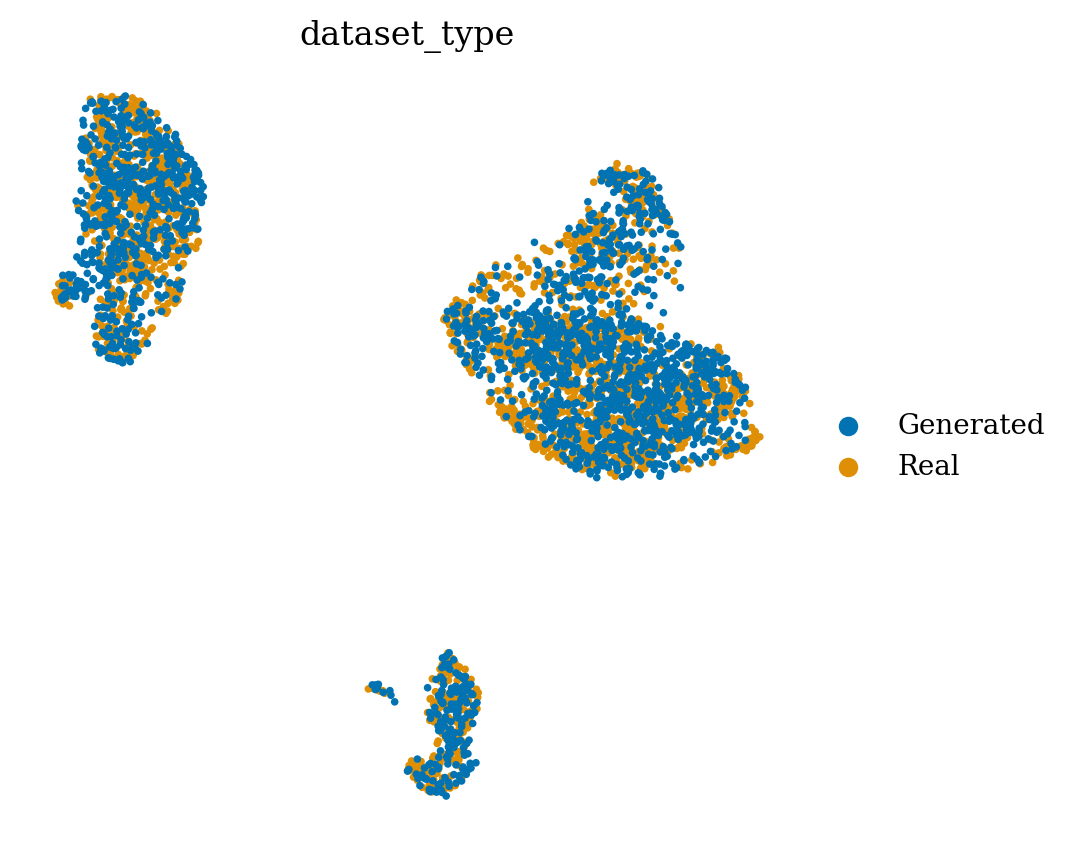

In [58]:
sc.pl.umap(adata_merged_rna, color="dataset_type", palette=palette, s=30,add_outline=False, save="RNA.png")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


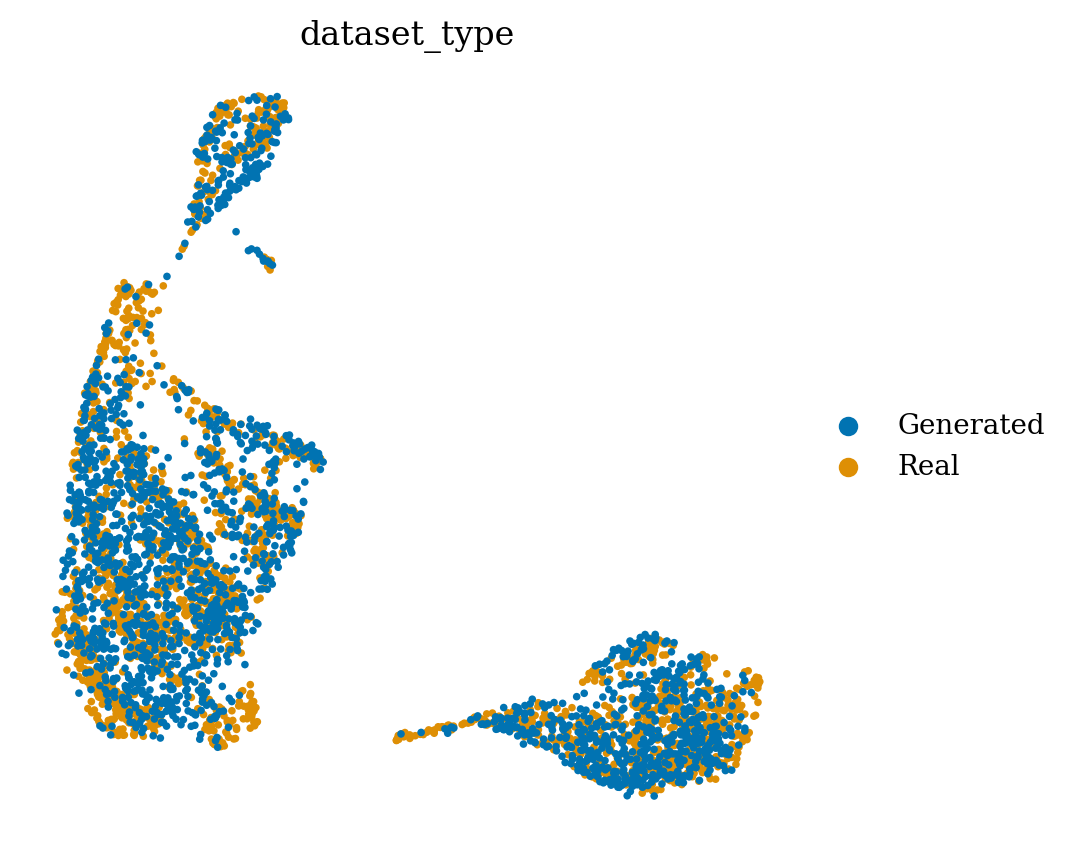

In [59]:
sc.pl.umap(adata_merged_atac, color="dataset_type", palette=palette, s=30,add_outline=False, save="RNA.png")